In [1]:
import torch
import torch.nn as nn
import scipy.io as io
import matplotlib.pyplot as plt
import random
import src.utils.extractor as extractor
import src.training.data_augmentation as data_aug
import src.models.models as models
import src.training.self_supervision as ssl

/home/ids/edabier/miniconda3/envs/hsu-env/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ids/edabier/miniconda3/envs/hsu-env/lib/python3.14/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# n_em = 6
# vca = extractor.VCA()
# ems = vca.extract_endmembers(y, c=n_em)
# model = models.CNNAEU(B=y.shape[0], c=n_em)

# ems_mat = [torch.zeros(0)]*n_em
# ems_mat = [torch.cat((ems_mat[i], ems[:,i].repeat(4))).reshape(ems.shape[0], 2, 2).unsqueeze(0) for i in range(n_em)]
# unmixed_ems = [model.encoder(ems_mat[i]) for i in range(n_em)]

# ce = nn.CrossEntropyLoss()
# # Cross entropy between ems and unmixed ems
# loss = torch.sum([ce(ems[:,i], unmixed_ems[i]) for i in range(n_em)])

In [3]:
# def generate_hsi(h=9,w=9,b=4):
#     hsi = torch.zeros(b, h, w)
    
#     checkerboard = torch.zeros(h, w)
#     for i in range(h):
#         for j in range(w):
#             checkerboard[i, j] = (i + j) % 2

#     # Generate slightly varying values for each tile
#     checkerboard_varied = torch.zeros(h, w)
#     for i in range(h):
#         for j in range(w):
#             base_value = checkerboard[i, j]  # Base value: 0 or 1
#             perturbation = torch.rand(1).item() * 0.2 - 0.1  # Small random perturbation between -0.1 and 0.1
#             checkerboard_varied[i, j] = base_value + perturbation  # Clamp to [0, 1]
#     checkerboard = checkerboard_varied
    
#     # Generate variations for each channel
#     for k in range(b):
#         # Random scaling and offset for each channel
#         scale = torch.rand(1).item() * 0.5 + 0.5  # Scale between 0.5 and 1.0
#         offset = torch.rand(1).item() * 0.2       # Offset between 0 and 0.2

#         # Apply variation to the checkerboard
#         hsi[k, :, :] = (checkerboard * scale + offset).clamp(0, 1)

#     # Normalize each spectral vector to sum to 1
#     hsi = hsi / hsi.sum(dim=0, keepdim=True)

#     return hsi

# hsi = generate_hsi(h=32, w=32, b=15)
# b, h, w = hsi.shape

In [4]:
data = io.loadmat("/home/ids/edabier/HSU/SS-HSU_benchmark/datasets/apex.mat")
hsi = torch.tensor(data["Y"])

In [5]:
hsi.shape

torch.Size([285, 12100])

In [6]:
model = models.CNNAEU(hsi.shape[0], c=4)
trainer = ssl.ContrastiveLearning(model, model)
patch_size = int((hsi.shape[1]**0.5)*0.5)
neg_patches = trainer.find_negative_patches(hsi, c=4, n_patches=3, patch_size=patch_size, patch_pos=(0,0), average=True)

input SNR estimated = 24.330549240112305[dB]
Indices chosen to be the most pure: tensor([1438, 6900, 7358, 2128])


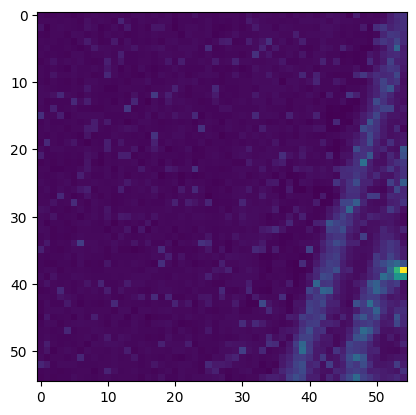

In [7]:
Y_reshaped = hsi.reshape(hsi.shape[0], int(hsi.shape[1]**0.5), int(hsi.shape[1]**0.5))
plt.imshow(Y_reshaped[0,:patch_size,:patch_size])

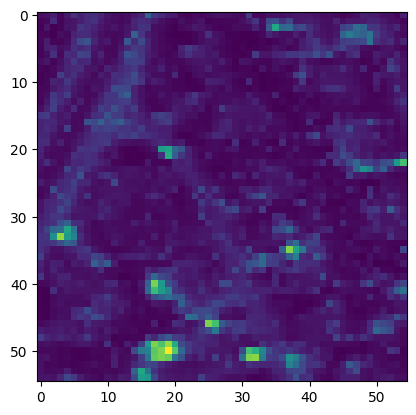

In [15]:
patch_i = 0
plt.imshow(Y_reshaped[0, neg_patches[patch_i][0]:neg_patches[patch_i][0]+patch_size, neg_patches[patch_i][1]:neg_patches[patch_i][1]+patch_size])

In [6]:
n_em = 6
n_vca = 10
n_aug = 10
c_var=0.4
endmember_lib = torch.tensor([])

for _ in range(n_vca):
    e = extractor.VCA(hsi, c=n_em) # shape (B, c)
    endmember_lib = torch.cat((endmember_lib, e), dim=1)

# We remove duplicate ems and normalize them
unique_spectra = data_aug.remove_duplicates(endmember_lib, tol=1e-4)
norms = torch.linalg.norm(unique_spectra, dim=1, keepdim=True)
unique_spectra_norm = unique_spectra / norms # shape (B, c*nb_spectra_in_cluster)

# We use Kmeans to cluster the ems to create exactly c categories
centers, memberships = data_aug.group_spectra_kmeans(unique_spectra_norm.T, n_clusters=n_em)
grouped_lib = data_aug.group_spectra_by_cluster(unique_spectra_norm, memberships) # shape (c, B, nb_spectra_in_cluster)

# We augment the number of ems in each cluster by running n_aug times the augmentation function
# Augmented_lib has shape (c, B, n_aug*nb_spectra_in_cluster)
augmented_lib = [
    torch.cat([torch.stack([data_aug.augment_spectrum(group[:, i], c_var).nan_to_num(nan=0.0) for _ in range(n_aug)], dim=1)
            for i in range(group.shape[1])], dim=1)
for group in grouped_lib]
e_avg = torch.stack([torch.mean(augmented_lib[i], dim=1, keepdim=True) for i in range(n_em)], dim=1).squeeze(2)

input SNR estimated = 30.963518142700195[dB]
Indices chosen to be the most pure: tensor([ 1438,  7358,  2128,  6900, 10882,  9541])
input SNR estimated = 30.963518142700195[dB]
Indices chosen to be the most pure: tensor([ 1438,  2128,  9541,  8224,  9543, 10882])
input SNR estimated = 30.963518142700195[dB]
Indices chosen to be the most pure: tensor([ 1438,  9543,  2851,  9541,  2128, 10882])
input SNR estimated = 30.963518142700195[dB]
Indices chosen to be the most pure: tensor([1438, 8224, 2128, 1269, 9541, 9543])
input SNR estimated = 30.963518142700195[dB]
Indices chosen to be the most pure: tensor([ 1438,  2851,  2128,  9543, 10882,  9541])
input SNR estimated = 30.963518142700195[dB]
Indices chosen to be the most pure: tensor([ 1438,  2128,  6900,  9541,  9543, 10772])
input SNR estimated = 30.963518142700195[dB]
Indices chosen to be the most pure: tensor([ 1438,  5475,  7358,  2128,  9541, 10882])
input SNR estimated = 30.963518142700195[dB]
Indices chosen to be the most pure: t

In [7]:
Y = hsi
if Y.dim() != 2:
    Y = Y.reshape(Y.shape[0], Y.shape[1]*Y.shape[2])
B1, N = Y.shape
B2, c = e_avg.shape

if B1 != B2:
    raise ValueError("M and U must have the same number of spectral bands.")

eet = e_avg.T @ e_avg
eet_inv = torch.linalg.inv(eet)
eet_inv_eT = eet_inv @ e_avg.T  # (c x p)

# Unconstrained least squares for all pixels: (c x N)
abd_ls = eet_inv_eT @ Y

# Apply sum-to-one constraint
ones_row = torch.ones(1, c, device=Y.device)
ones_col = torch.ones(c, 1, device=Y.device)
scaling = ones_row @ eet_inv @ ones_col
sum_ls = ones_row @ abd_ls  # (1 x N)
abd_fcls = abd_ls - eet_inv @ ones_col @ (1 / scaling) * (sum_ls - 1)

# Clip negative abundances to zero
abd_clipped = torch.clamp(abd_fcls, min=0)
sum_abd = torch.sum(abd_clipped, dim=0, keepdim=True)  # (1 x N)
# Avoid division by zero (if all abundances are zero for a pixel)
sum_abd[sum_abd == 0] = 1  # Set to 1 to avoid NaN
A = abd_clipped / sum_abd

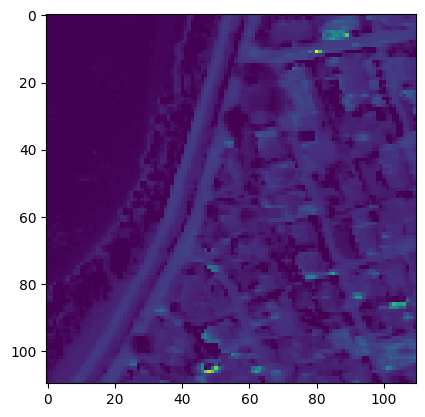

In [11]:
A_reshaped = A.reshape(A.shape[0], int(A.shape[1]**0.5), int(A.shape[1]**0.5))
plt.imshow(A_reshaped[0,:,:])

In [13]:
import pywt

x = [i for i in range(10)]

# DWT of x using bior3.3
xA, xD = pywt.dwt(x, 'bior3.3')

# IDWT of xA and xD using bior3.3
x_hat = pywt.idwt(xA, xD, 'bior3.3')

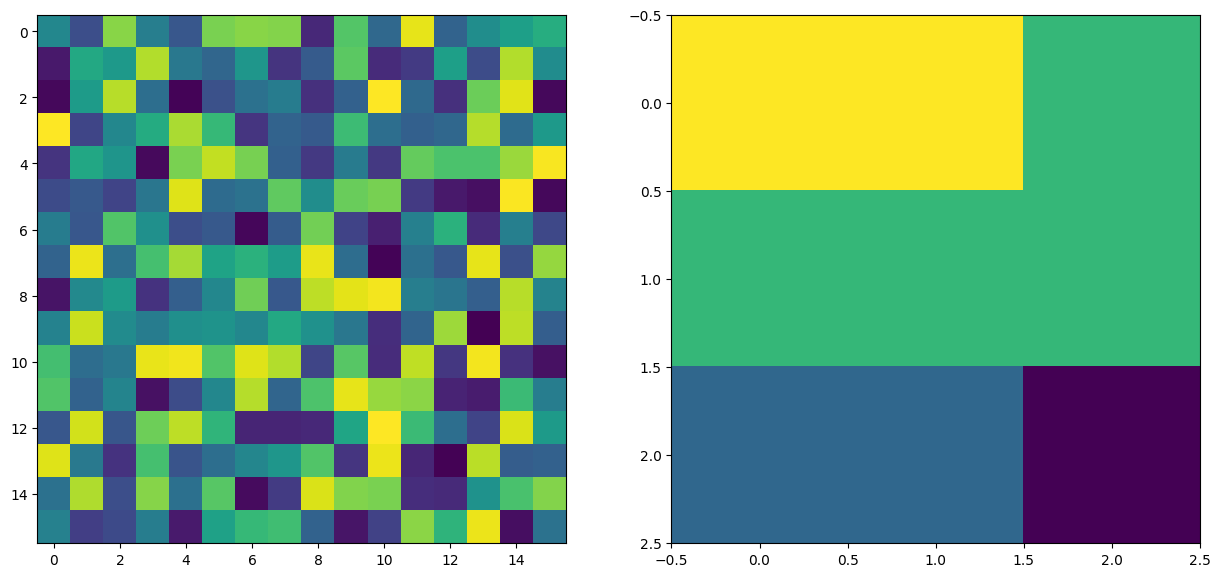

In [14]:
import torch
import matplotlib.pyplot as plt
import data_augmentation as aug

y = 256*torch.rand(4, 16, 16)
y1 = torch.tensor([[3,3,2], [2, 2, 2], [1, 1, 0]])
y1 = y1.unsqueeze(0).repeat(4, 1, 1)

fig, axs = plt.subplots(1,2, figsize=(15,10))
axs[0].imshow(y[0,:,:])
axs[1].imshow(y1[0,:,:])

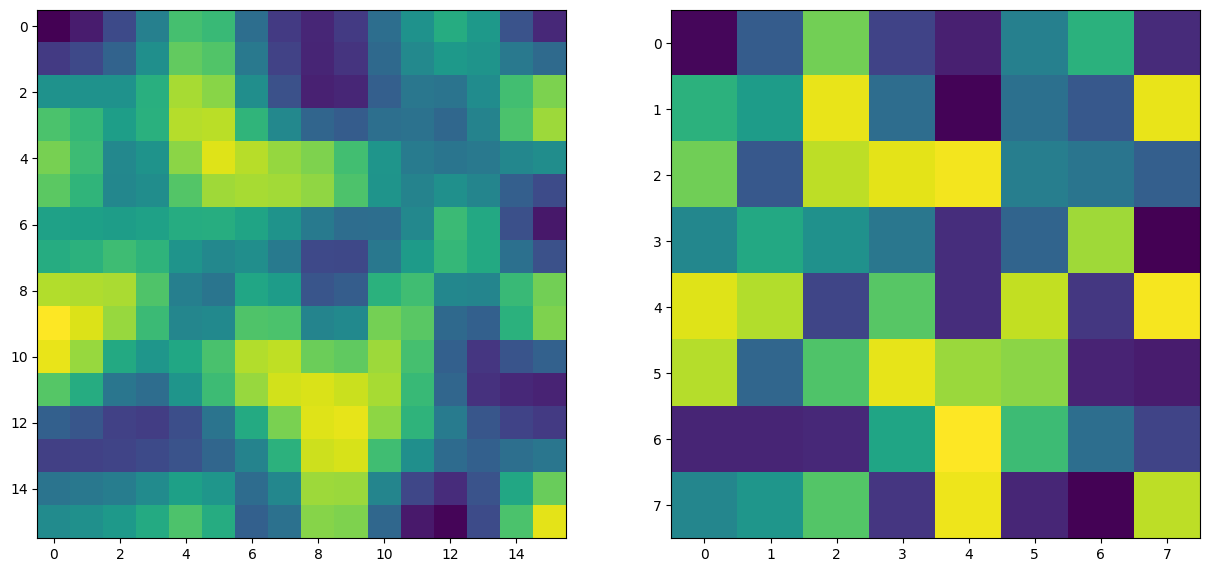

In [15]:
y2, (x_,y_), (r1,r2) = aug.crop_and_resize(y, 0.5, return_position=True)

fig, axs = plt.subplots(1,2, figsize=(15,10))
axs[0].imshow(y2[0,:,:])
axs[1].imshow(y[0,x_:x_+r1,y_:y_+r2])

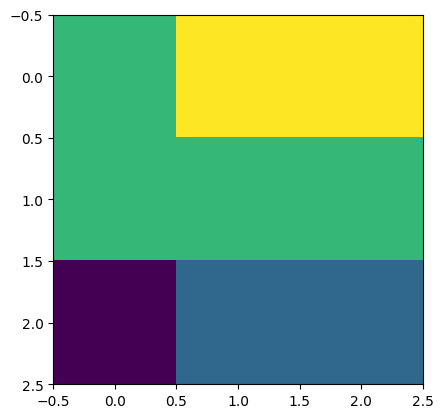

In [16]:
y3 = aug.flip(y1)

plt.imshow(y3[0,:,:])

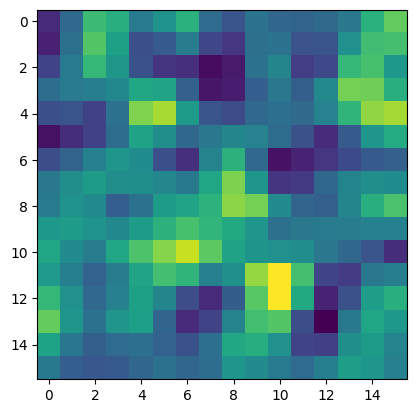

In [17]:
y4 = aug.blur(y, r=3, sigma=0.9)

plt.imshow(y4[0,:,:])

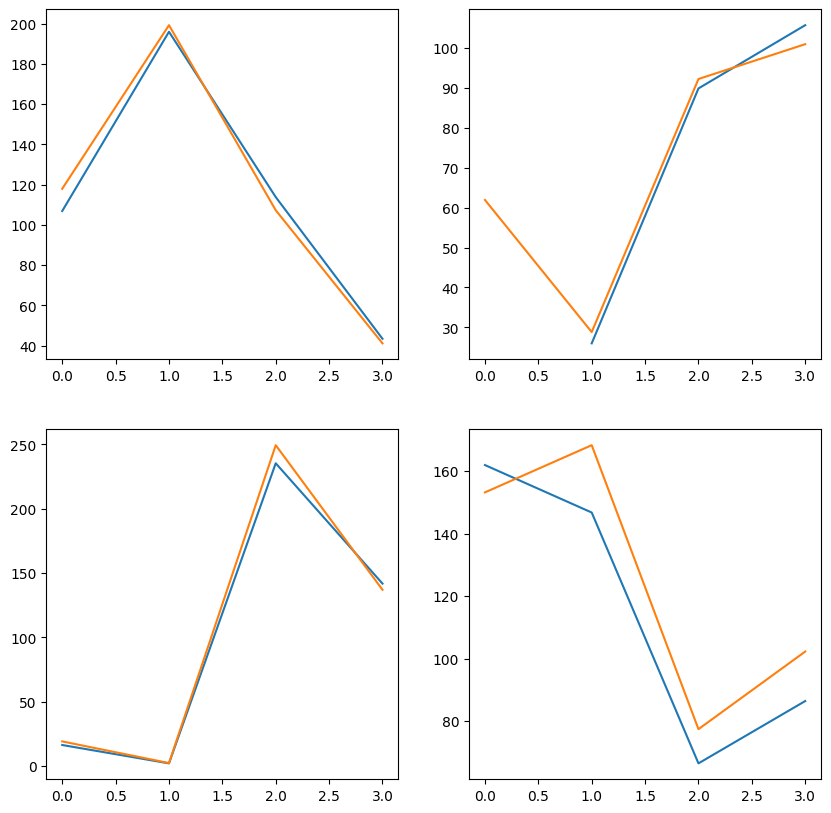

In [18]:
y5 = aug.spectral_variability(y, 0.4)

fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0,0].plot(y5[:,0,0])
axs[0,0].plot(y[:,0,0])

axs[0,1].plot(y5[:,0,1])
axs[0,1].plot(y[:,0,1])

axs[1,0].plot(y5[:,1,0])
axs[1,0].plot(y[:,1,0])

axs[1,1].plot(y5[:,1,1])
axs[1,1].plot(y[:,1,1])